In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from numba import jit 
from sklearn.metrics import mean_squared_error, r2_score
@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e


def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

def qwk_score(y_true,y_pred):
    #print "RMSE", np.sqrt(mean_squared_error(y_true,y_pred))
    ypred=clip_pred(y_pred)
    return qwk(y_true,ypred)
    

In [3]:
import fastparquet
%time df=fastparquet.ParquetFile("../../input/train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 3.19 s, sys: 1.72 s, total: 4.91 s
Wall time: 21.4 s


In [4]:
df=df.loc[np.random.permutation(df.index)]
X=df.drop(['target','fold'],axis=1)
y=df['target']
trainx=X[y>=0]
trainy=y[y>=0]
testx=X[y<0]
folds=df[y>=0]['fold']
print trainx.shape,testx.shape,trainy.shape, len(folds),set(trainy)

(5203955, 54) (1378521, 54) (5203955,) 5203955 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20])


In [5]:
del df,X,y
gc.collect()

9974

In [6]:
from sklearn.ensemble import RandomForestRegressor

# cv

In [7]:
from sklearn.model_selection import GridSearchCV,ParameterGrid
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [8]:
def train():
    lst_valid=[]
    lst_test=[]
    for fold in range(5):
        print fold
        X_train=trainx[(folds<>fold)]
        y_train=trainy[(folds<>fold)]
        X_valid=trainx[(folds==fold)]
        y_valid=trainy[(folds==fold)]
        regr = RandomForestRegressor(n_estimators=100,n_jobs=11,max_features='log2',min_samples_leaf=12,max_depth=8)
        param={'max_depth': 10, 'min_samples_leaf': 20, 'n_estimators': 100}
        regr.set_params(**param)
        regr.fit(X_train,y_train)
        lst_test.append(pd.Series(regr.predict(testx),index=testx.index))
        lst_valid.append(pd.Series(regr.predict(X_valid),index=X_valid.index))
        print fold, regr.score(X_valid,y_valid) 
    return lst_valid,lst_test

In [9]:
lst_valid,lst_test=train()

0
0 0.572679445015
1
1 0.574394298901
2
2 0.57350444788
3
3 0.574344894503
4
4 0.572674220167


In [10]:
name='rf0'

In [11]:
l1_test_pred=(reduce(lambda u,v:u+v,lst_test)/float(len(lst_test))).astype(np.float32)
l1_test_pred.name=name+"_pred"
l1_train_pred=pd.concat(lst_valid).loc[trainx.index].astype(np.float32)
l1_train_pred.name=name+"_pred"
np.sqrt(r2_score(trainy,l1_train_pred)),qwk_score(trainy,l1_train_pred),mean_squared_error(trainy,l1_train_pred)

(0.75731077326263252, 0.7143608347209907, 3.7655222)

In [12]:
import cPickle as pickle
pickle.dump(l1_train_pred,open("../level1_train/{}_train_l1pred.pkl".format(name),'wb'))
pickle.dump(l1_test_pred,open("../level1_train/{}_test_l1pred.pkl".format(name),'wb'))

In [3]:
import cPickle as pickle
import numpy as np

0.891908792104 0.988578895008


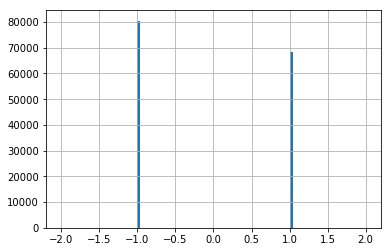

In [4]:
a=clip_pred(pickle.load(open("../level1_train/rf0_test_l1pred.pkl")))
b=clip_pred(pickle.load(open("../level1_train/rf1_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)

0.695433003922 0.968635153949


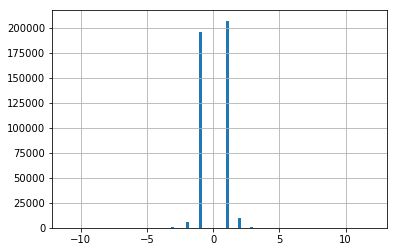

In [5]:
a=clip_pred(pickle.load(open("../level1_train/rf0_test_l1pred.pkl")))
b=clip_pred(pickle.load(open("../level1_train/ridge1_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)

0.651940013971 0.96817980285


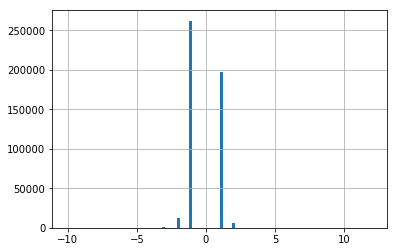

In [6]:
a=clip_pred(pickle.load(open("../level1_train/rf0_test_l1pred.pkl")))
b=clip_pred(pickle.load(open("../level1_train/ridge0_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)